# Kish Basin Salt Caverns

<https://hyss.ie/>

In [1]:
import os
from zipfile import BadZipFile, ZipFile
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import pooch
import glob
from datetime import datetime, timezone
from shapely.geometry import Polygon
import rioxarray as rxr
from geocube.api.core import make_geocube
from textwrap import wrap
import numpy as np
import shapely

In [2]:
# base data download directory
DATA_DIR = os.path.join("data", "kish-basin")
FILE_NAME = "Kish-Basin-dat-files.zip"

DATA_FILE = os.path.join(DATA_DIR, FILE_NAME)

# boundary data
ie = gpd.read_file(
    os.path.join("data", "boundaries.gpkg"), layer="NUTS_RG_01M_2021_4326_IE"
)

crs = 23029

## Read data layers

In [140]:
def read_dat_file(dat_path: str, dat_crs):
    """
    Read XYZ data layers into an Xarray dataset
    """

    gdf = {}
    for dat_file in glob.glob(dat_path):
        # read each layer as individual dataframes into a dictionary
        gdf[os.path.split(dat_file)[1][:-4]] = pd.read_fwf(
            dat_file, header=None, names=["X", "Y", "Z"]
        )

        # assign layer name to a column
        gdf[os.path.split(dat_file)[1][:-4]]["data"] = (
            os.path.split(dat_file)[1][:-4]
        )
    
    # combine dataframes
    gdf = pd.concat(gdf.values())

    # convert dataframe to geodataframe
    gdf["wkt"] = (
        "POINT (" + gdf["X"].astype(str) + " " + gdf["Y"].astype(str) + ")"
    )
    gdf = gpd.GeoDataFrame(
        gdf, geometry=gpd.GeoSeries.from_wkt(gdf["wkt"]), crs=dat_crs
    )
    gdf.drop(columns=["wkt", "X", "Y"], inplace=True)

    # convert to Xarray dataset
    ds = make_geocube(
        vector_data=gdf, resolution=(200, -200), group_by="data"
    )

    # keep only zones of interest in the dataframe
    gdf = gdf.loc[gdf["data"].str.contains("Zone")]

    return gdf, ds

In [141]:
gdf, ds = read_dat_file(os.path.join(DATA_DIR, "*.dat"), dat_crs=crs)

### Map extent

In [3]:
# create extent polygon
extent = pd.read_csv(
    os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
)
extent = gpd.GeoSeries(
    Polygon([
        (extent[" X"][0], extent[" Y"][0]),
        (extent[" X"][1], extent[" Y"][1]),
        (extent[" X"][2], extent[" Y"][2]),
        (extent[" X"][3], extent[" Y"][3])
    ]),
    crs=crs
)

In [157]:
extent.bounds

,minx,miny,maxx,maxy
0,687000.0,5888000.0,742000.0,5937000.0


### Halite layers

In [142]:
ds

<xarray.Dataset>
Dimensions:      (data: 19, y: 236, x: 217)
Coordinates:
  * y            (y) float64 5.889e+06 5.89e+06 5.89e+06 ... 5.936e+06 5.936e+06
  * x            (x) float64 7.399e+05 7.397e+05 ... 6.969e+05 6.967e+05
  * data         (data) <U66 'Flyde Halite Base Depth XYZ Meters' ... 'Rossal...
    spatial_ref  int64 0
Data variables:
    Z            (data, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [143]:
ds.rio.crs

CRS.from_epsg(23029)

In [144]:
ds.rio.resolution()

(-200.0, 200.0)

In [155]:
ds.rio.bounds()

(696600.0, 5889200.0, 740000.0, 5936400.0)

### Zone of interest points

In [145]:
gdf.shape

(977, 3)

In [146]:
gdf.head()

,Z,data,geometry
0,315.3059,Flyde Halite Thickness - Zone Of Interest - XY...,POINT (708600.000 5919600.000)
1,313.1337,Flyde Halite Thickness - Zone Of Interest - XY...,POINT (708600.000 5919400.000)
2,308.6101,Flyde Halite Thickness - Zone Of Interest - XY...,POINT (708800.000 5919400.000)
3,300.9216,Flyde Halite Thickness - Zone Of Interest - XY...,POINT (708800.000 5919200.000)
4,322.6699,Flyde Halite Thickness - Zone Of Interest - XY...,POINT (716400.000 5924400.000)


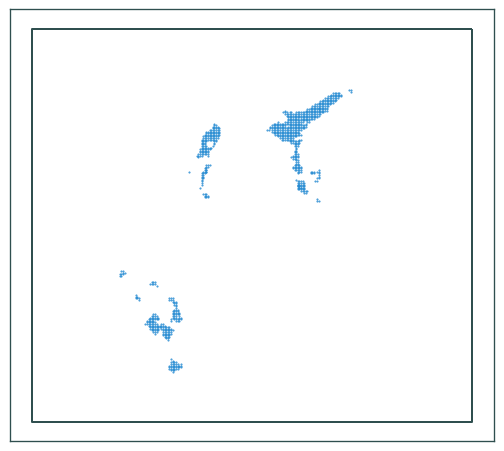

In [148]:
ax = gdf.plot(markersize=.25)
extent.boundary.plot(ax=ax, color="darkslategrey")
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

### Zone of interest boundaries

In [150]:
zones = gpd.GeoSeries(gdf["geometry"].buffer(200).unary_union, crs=crs)

In [151]:
zones

0    MULTIPOLYGON (((702526.879 5898845.398, 702511...
dtype: geometry

In [152]:
zones.bounds

,minx,miny,maxx,maxy
0,697800.0,5894000.0,727000.0,5929600.0


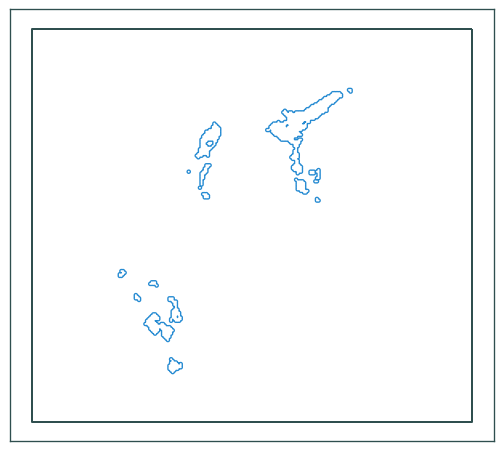

In [156]:
ax = zones.boundary.plot(linewidth=1)
extent.boundary.plot(ax=ax, color="darkslategrey")
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

### Cavern specifications

In [158]:
# cavern specifications
diameter = 84
separation = diameter * 4

In [159]:
separation

336

### Generate salt cavern grid using extent

In [160]:
xmin, ymin, xmax, ymax = (
    extent.bounds["minx"][0], extent.bounds["miny"][0],
    extent.bounds["maxx"][0], extent.bounds["maxy"][0]
)

In [161]:
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax + separation, separation):
    for y0 in np.arange(ymin, ymax + separation, separation):
        # bounds
        x1 = x0 - separation
        y1 = y0 + separation
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
grid_cells = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)

In [163]:
# verify separation distance
x0 - x1, y0 - y1

(336.0, -336.0)

In [165]:
grid_cells.head()

,geometry
0,"POLYGON ((686664.000 5888000.000, 686664.000 5..."
1,"POLYGON ((686664.000 5888336.000, 686664.000 5..."
2,"POLYGON ((686664.000 5888672.000, 686664.000 5..."
3,"POLYGON ((686664.000 5889008.000, 686664.000 5..."
4,"POLYGON ((686664.000 5889344.000, 686664.000 5..."


In [166]:
grid_cells.shape

(24255, 1)

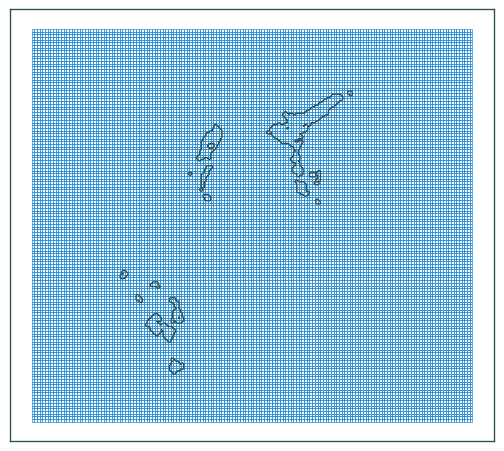

In [168]:
ax = grid_cells.boundary.plot(linewidth=.5)
zones.boundary.plot(ax=ax, linewidth=1, color="darkslategrey")
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

### Caverns in zone of interest

In [170]:
caverns = gpd.GeoDataFrame(
    geometry=grid_cells.centroid.buffer(diameter / 2)
).overlay(
    gpd.GeoDataFrame(geometry=zones), how="intersection",  # keep_geom_type=False
)

In [171]:
caverns.head()

,geometry
0,"POLYGON ((697920.000 5906018.000, 697924.117 5..."
1,"POLYGON ((697961.798 5906307.883, 697961.193 5..."
2,"POLYGON ((698223.534 5906002.645, 698226.302 5..."
3,"POLYGON ((698297.798 5906307.883, 698297.193 5..."
4,"POLYGON ((698297.798 5906643.883, 698297.193 5..."


In [172]:
caverns.shape

(498, 1)

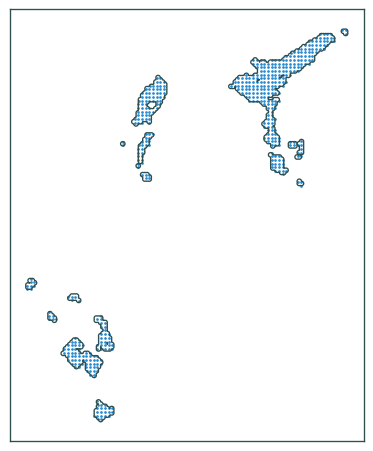

In [175]:
ax = caverns.centroid.plot(markersize=1)
zones.boundary.plot(ax=ax, linewidth=1, color="darkslategrey")
plt.tick_params(labelbottom=False, labelleft=False)
plt.tight_layout()
plt.show()

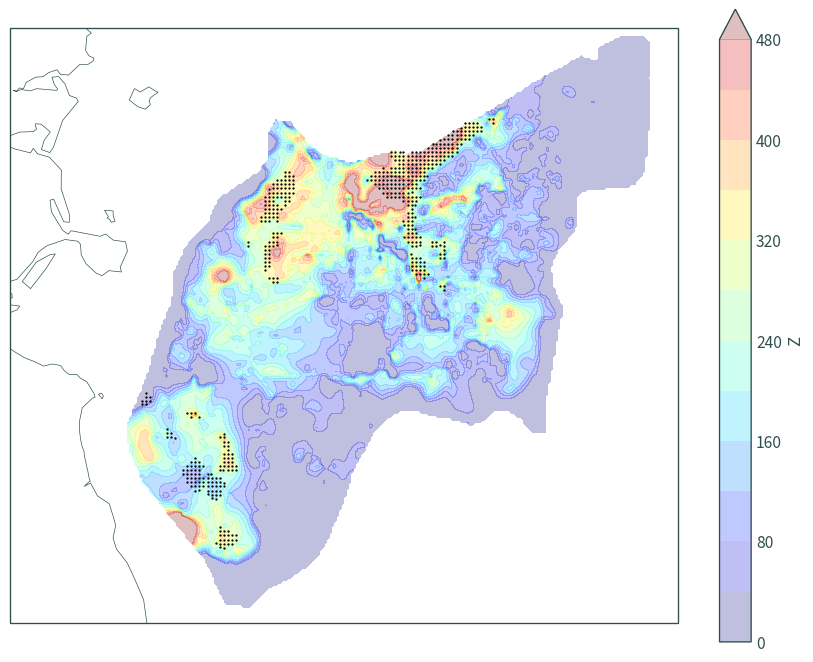

In [180]:
plt.figure(figsize=(9, 7))
ax = plt.axes(projection=ccrs.epsg(crs))
ds.sel(data="Rossall Halite Thickness XYZ Meters")["Z"].plot.contourf(
    ax=ax,
    cmap="jet",
    alpha=.25,
    robust=True,
    levels=15,
    transform=ccrs.epsg(crs),
    xlim=(687000, 742000),
    ylim=(5888000, 5937000),
)
caverns.centroid.plot(ax=ax, markersize=2, marker=".", color="black")
ie.to_crs(crs).boundary.plot(ax=ax, edgecolor="darkslategrey", linewidth=.5)
plt.title("")
plt.tight_layout()
plt.show()